# Overview 

This notebook was used to create the dataset used in the paper:

"Association between Circadian Variation and Mortality in Critically Ill Patients: Insights from the eICU Collaborative Research Database".

Data for this study were obtained from the [eICU Collaborative Research Database](https://www.nature.com/articles/sdata2018178#article-info) v2.0, published in April 15, 2019. This is a large multi–center critical care database made available by Philips Healthcare in partnership with the MIT Laboratory for Computational Physiology. We do not provide the eICU data. You must acquire the data yourself from https://eicu-crd.mit.edu/ after completion of the CITI "Data or Specimens Only Research" course. You will need to download the following tables from the eICU database:
    
* patient.csv
* apachePatientResult.csv
* vitalaperiodic.csv
* vitalperiodic.csv
* medication.csv
* infusionDrug.csv

Aditionally, you will need to create a materialized view of Angus sepsis criteria following the query provided [here](https://github.com/kseverso/eicu-code/blob/5875ea8e400519d62a7a9d52e3ab94550dc00b41/concepts/angus_sepsis.sql), and save it into a csv file:

* angus_sepsis.csv


# Outline

## 1. [Import tables](#1)
## 2. [Inclusion criteria](#2)
### 2.1. [Adult patients](#21)
### 2.2. [One ICU stay per patient](#22)
### 2.3. [ICU LOS >= 3 days](#23)
### 2.4. [APACHE, gender, hospital discharge status](#24)
### 2.5. [Sepsis](#25)
## 3. [Preprocess mean arterial blood pressure (MAP)](#3)
### 3.1. [Exclude MAP observations collected before ICU admission](#31)
### 3.2. [Exclude MAP outliers](#32)
### 3.3. [Exclude patients with no records of MAP](#33)
### 3.4. [Derive the date of MAP observations](#34)
### 3.5. [Assign each observation to a day](#35)
## 4. [Add medications and infusions](#4)
## 5. [Calculate the median](#5)
### 5.1. [Plot](#51)
## 6. [Save the preprocessed data](#6)

# 1. Import tables <a class="anchor" id="1"></a>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

plt.style.use('ggplot')

base_path = '/Users/catiasalgado/eicu_data/'

patient = pd.read_csv(base_path + 'patient.csv',index_col='patientunitstayid')
patient.index = patient.index.astype(int)
apachePatientResult = pd.read_csv(base_path + 'apachePatientResult.csv',index_col='patientunitstayid')
angus = pd.read_csv(base_path + 'angus_sepsis.csv',index_col='patientunitstayid')
meds = pd.read_csv(base_path + 'medication.csv',index_col='patientunitstayid')
infusion = pd.read_csv(base_path + 'infusionDrug.csv',index_col='patientunitstayid')

display.display(patient.columns)
display.display(patient.head())

/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['patienthealthsystemstayid', 'gender', 'age', 'ethnicity', 'hospitalid',
       'wardid', 'apacheadmissiondx', 'admissionheight', 'hospitaladmittime24',
       'hospitaladmitoffset', 'hospitaladmitsource', 'hospitaldischargeyear',
       'hospitaldischargetime24', 'hospitaldischargeoffset',
       'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype',
       'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype',
       'admissionweight', 'dischargeweight', 'unitdischargetime24',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'uniquepid'],
      dtype='object')

,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,...,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851
141178,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,-14,...,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870
141179,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,-22,...,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870
141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,...,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276
141196,128943,Male,71,Caucasian,67,109,NaN,162.6,20:21:00,-99,...,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665


In [2]:
def printN(df):
    print('Number of patients = ' + str(df['uniquepid'].nunique()))
    print('Number of ICU admissions = ' + str(df.index.nunique()))
    print('Number of hospitalizations = ' + str(df['patienthealthsystemstayid'].nunique()))

print('eICU raw patient table:')
printN(patient)
n = patient['uniquepid'].nunique()


eICU raw patient table:
Number of patients = 139367
Number of ICU admissions = 200859
Number of hospitalizations = 166355


# 2. Inclusion criteria <a class="anchor" id="2"></a>
## 2.1. Adult patients <a class="anchor" id="21"></a>

In [3]:
patient['age'].unique()

array(['70', '52', '68', '71', '77', '25', '82', '> 89', '81', '59', '43',
       '19', '67', '73', '63', '61', '45', '76', '50', '72', '80', '48',
       '65', '78', '30', '75', '46', '39', '79', '58', '87', '60', '85',
       '83', '53', '86', '64', '55', '88', '84', '62', '56', '18', '38',
       '41', '35', '54', '74', '49', '51', '47', '33', '89', '66', '36',
       '69', '34', '44', '57', '22', '42', '27', '17', '37', '28', '40',
       '20', '32', '23', '24', '26', '29', '31', nan, '21', '15', '16',
       '0', '10', '1', '14', '12', '13', '8', '11', '2', '5', '4', '7',
       '3', '6', '9'], dtype=object)

In [4]:
#display.display(len(patient[patient['age'] == '> 89']))
patient.loc[patient['age'] == '> 89','age'] = '90'
patient['age'] = patient['age'].astype('float')


Exclude ICU stays where age is missing.

In [5]:
patient.dropna(axis = 0, how = 'any', inplace = True, subset = ['age'])

In [6]:
print('Number of patients with missing age: ' + str(n - patient['uniquepid'].nunique()))
printN(patient)
n = len(patient['uniquepid'].unique())


Number of patients with missing age: 74
Number of patients = 139293
Number of ICU admissions = 200764
Number of hospitalizations = 166271


Exclude non-adult patients

In [7]:
patient = patient[patient['age'] >= 15]

In [8]:
print('Number of patients with missing age: ' + str(n - patient['uniquepid'].nunique()))
printN(patient)
n = len(patient['uniquepid'].unique())

Number of patients with missing age: 108
Number of patients = 139185
Number of ICU admissions = 200634
Number of hospitalizations = 166150


## 2.2. One ICU stay per patient <a class="anchor" id="22"></a>
### First exclude patients with multiple hospital admissions

We're doing this because, according to the documentation, "there is no systematic method for chronologically ordering patientHealthSystemStayID for the same patient within the same year."

"Also note that there is no correlation between patientUnitStayID and the order of patient stays."



In [9]:
multipleHosp = patient.groupby(['uniquepid'])['patienthealthsystemstayid'].nunique()
multipleHosp = multipleHosp[multipleHosp > 1]
patient = patient[~patient['uniquepid'].isin(multipleHosp.index)]


In [10]:
print('Number of patients with multiple hospital admissions: ' + str(n - patient['uniquepid'].nunique()))
printN(patient)
n = len(patient['uniquepid'].unique())

Number of patients with multiple hospital admissions: 18867
Number of patients = 120318
Number of ICU admissions = 144701
Number of hospitalizations = 120318


### Then exclude all but the last ICU stay for patients with one hospital admission and more than one ICU stay

In [11]:
patient = patient.sort_values('unitvisitnumber').groupby('uniquepid').tail(1)


In [12]:
print('Number of patients does not change (only the number of ICU stays changes)')
printN(patient)
n = len(patient['uniquepid'].unique())

Number of patients does not change (only the number of ICU stays changes)
Number of patients = 120318
Number of ICU admissions = 120318
Number of hospitalizations = 120318


## 2.3. ICU LOS >= 3 days <a class="anchor" id="23"></a>

'unitdischargeoffset' gives the offset in minutes between ICU admission and ICU discharge

In [13]:
patient['ICULOSdays'] = patient['unitdischargeoffset'] / (60*24)
patient['HosLOSdays'] = patient['hospitaldischargeoffset'] / (60*24)

patient = patient[patient['ICULOSdays'] >= 3]

In [14]:
print('Number of patients with ICU LOS < 3 days: ' + str(n - patient['uniquepid'].nunique()))
printN(patient)
n = len(patient['uniquepid'].unique())

Number of patients with ICU LOS < 3 days: 91528
Number of patients = 28790
Number of ICU admissions = 28790
Number of hospitalizations = 28790


## 2.4. APACHE, gender, hospital discharge status <a class="anchor" id="24"></a>

### APACHE

In [15]:
# select one version of APACHE
apachePatientResult = apachePatientResult[apachePatientResult['apacheversion'] == 'IVa']

# make sure only one value is available by stay
apachePatientResult.groupby(apachePatientResult.index)['apachescore'].nunique().unique()

array([1])

In [16]:
# concatenate with patient table
patient = pd.merge(patient, apachePatientResult, how='left', left_index=True, right_index=True)
# patient = pd.concat([patient, apachePatientResult], axis=1, join_axes=[patient.index])
patient.dropna(axis = 0, how = 'any', inplace = True, subset = ['apachescore'])


In theory, the maximum APACHE IV score is 286. 

source: https://intensivecarenetwork.com/Calculators/Files/Apache4.html

211.0

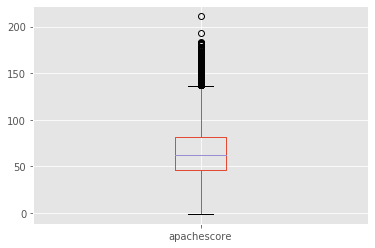

In [17]:
patient['apachescore'].plot.box()
max(patient['apachescore'])

In [18]:
print('Number of patients with missing APACHE: ' + str(n - patient['uniquepid'].nunique()))
printN(patient)
n = len(patient['uniquepid'].unique())

Number of patients with missing APACHE: 3903
Number of patients = 24887
Number of ICU admissions = 24887
Number of hospitalizations = 24887


### Gender

In [19]:
# Count gender categories
display.display(patient.groupby(['gender'])['uniquepid'].count())

# change to numeric (there is only one 'other' gender, we will assume it is missing)
patient.loc[patient['gender'] == 'Female','gender'] = 0
patient.loc[patient['gender'] == 'Male','gender'] = 1
patient.loc[patient['gender'] == 'Other','gender'] = float('nan')
patient.loc[patient['gender'] == 'Unknown','gender'] = float('nan')

# drop nans
patient.dropna(axis = 0, how = 'any', inplace = True, subset = ['gender'])
patient['gender'] = patient['gender'].astype(int)
# patient['genderNum'] = patient['gender']


gender
Female     11135
Male       13749
Other          1
Unknown        2
Name: uniquepid, dtype: int64

In [20]:
print('Number of patients with missing gender: ' + str(n - patient['uniquepid'].nunique()))
printN(patient)
n = len(patient['uniquepid'].unique())

Number of patients with missing gender: 3
Number of patients = 24884
Number of ICU admissions = 24884
Number of hospitalizations = 24884


### Hospital dischage status

In [21]:
# Count categories
display.display(patient.groupby(['hospitaldischargestatus'])['uniquepid'].count())

# change to numeric 
patient.loc[patient['hospitaldischargestatus'] == 'Alive','hospitaldischargestatus'] = 0
patient.loc[patient['hospitaldischargestatus'] == 'Expired','hospitaldischargestatus'] = 1
patient['mortality'] = patient['hospitaldischargestatus']

# drop nans
patient.dropna(axis = 0, how = 'any', inplace = True, subset = ['mortality'])


hospitaldischargestatus
Alive      20734
Expired     4150
Name: uniquepid, dtype: int64

In [22]:
print('Number of patients with missing hospital discharge status: ' + str(n - patient['uniquepid'].nunique()))
print('After excluding patients with multiple hospitalizations, with missing age, age < 15 years, ICU LOS < 3 days, missing APACHE, missing gender, missing hospital discharge status:')
printN(patient)
n = len(patient['uniquepid'].unique())

Number of patients with missing hospital discharge status: 0
After excluding patients with multiple hospitalizations, with missing age, age < 15 years, ICU LOS < 3 days, missing APACHE, missing gender, missing hospital discharge status:
Number of patients = 24884
Number of ICU admissions = 24884
Number of hospitalizations = 24884


## 2.5. Sepsis <a class="anchor" id="25"></a>


In [23]:
patient = pd.merge(patient, angus, how='left', left_index=True, right_index=True)
# patient = pd.concat([patient, angus], axis=1, join_axes=[patient.index])


In [24]:
n2 = patient[patient['angus'].isna()].index.nunique()
print('Number of patients with missing sepsis: ' + str(n2))
printN(patient)
n = len(patient['uniquepid'].unique())

Number of patients with missing sepsis: 0
Number of patients = 24884
Number of ICU admissions = 24884
Number of hospitalizations = 24884


# 3. Preprocess mean arterial blood pressure (MAP) <a class="anchor" id="3"></a>

Data will be imported in chunks from the 'vitalaperiodic' and 'vitalperiodic' tables, for the population of interest defined in the dataframe patient. Don't forget to change the name of the path.

### table vitalaperiodic

In [25]:
import math

# observationoffset: number of minutes from unit admit time that the periodic value was entered
columns_of_interest = ['observationoffset', 'noninvasivemean']
icustays_of_interest = patient.index.unique()

chunksize = 10 ** 6
chunks = []

# CSV, being row-based, does not allow a process to know how many lines there are in it until after it has all been scanned.
# Very minimal scanning is necessary, though, assuming the CSV file is well formed:
# Change the name of the path
nrows = sum(1 for row in open('/Users/catiasalgado/eICU_data/vitalaperiodic.csv', 'r'))
print('Number of rows in csv: ' + str(nrows))
nchunks = math.ceil(nrows/chunksize)
print('Number of chunks: ' + str(nchunks))

for chunk in pd.read_csv('/Users/catiasalgado/eICU_data/vitalaperiodic.csv', index_col='patientunitstayid' , chunksize=chunksize):
    chunk = chunk[columns_of_interest]
    chunk = chunk.loc[icustays_of_interest]
    chunk.dropna(axis = 0, how = 'any', inplace=True)
    chunks.append(chunk)
    print(str(len(chunks)) + '/' + str(nchunks))

dataap = pd.concat(chunks)
# convert observationoffset to hours
dataap['observationoffset'] = dataap['observationoffset']/60


Number of rows in csv: 25075075
Number of chunks: 26


/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


1/26
2/26
3/26
4/26
5/26
6/26
7/26
8/26
9/26
10/26
11/26
12/26
13/26
14/26
15/26
16/26
17/26
18/26
19/26
20/26
21/26
22/26
23/26
24/26
25/26
26/26


### table vitalperiodic

In [26]:
import math

# observationoffset: number of minutes from unit admit time that the periodic value was entered
columns_of_interest = ['observationoffset', 'systemicmean']
icustays_of_interest = patient.index.unique()

chunksize = 10 ** 6
chunks = []

# CSV, being row-based, does not allow a process to know how many lines there are in it until after it has all been scanned.
# Very minimal scanning is necessary, though, assuming the CSV file is well formed:
# Change the name of the path
nrows = sum(1 for row in open('/Users/catiasalgado/eICU_data/vitalperiodic.csv', 'r'))
print('Number of rows in csv: ' + str(nrows))
nchunks = math.ceil(nrows/chunksize)
print('Number of chunks: ' + str(nchunks))

for chunk in pd.read_csv('/Users/catiasalgado/eICU_data/vitalperiodic.csv', index_col='patientunitstayid' , chunksize=chunksize):
    chunk = chunk[columns_of_interest]
    chunk = chunk.loc[icustays_of_interest]
    chunk.dropna(axis = 0, how = 'any', inplace=True)
    chunks.append(chunk)
    print(str(len(chunks)) + '/' + str(nchunks))

datap = pd.concat(chunks)
# convert observationoffset to hours
datap['observationoffset'] = datap['observationoffset']/60
# change name to concatenate with vitalaperiodic
datap.rename(columns={'systemicmean': 'noninvasivemean'}, inplace=True)


Number of rows in csv: 146671643
Number of chunks: 147


/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


1/147
2/147
3/147
4/147
5/147
6/147
7/147
8/147
9/147
10/147
11/147
12/147
13/147
14/147
15/147
16/147
17/147
18/147
19/147
20/147
21/147
22/147
23/147
24/147
25/147
26/147
27/147
28/147
29/147
30/147
31/147
32/147
33/147
34/147
35/147
36/147
37/147
38/147
39/147
40/147
41/147
42/147
43/147
44/147
45/147
46/147
47/147
48/147
49/147
50/147
51/147
52/147
53/147
54/147
55/147
56/147
57/147
58/147
59/147
60/147
61/147
62/147
63/147
64/147
65/147
66/147
67/147
68/147
69/147
70/147
71/147
72/147
73/147
74/147
75/147
76/147
77/147
78/147
79/147
80/147
81/147
82/147
83/147
84/147
85/147
86/147
87/147
88/147
89/147
90/147
91/147
92/147
93/147
94/147
95/147
96/147
97/147
98/147
99/147
100/147
101/147
102/147
103/147
104/147
105/147
106/147
107/147
108/147
109/147
110/147
111/147
112/147
113/147
114/147
115/147
116/147
117/147
118/147
119/147
120/147
121/147
122/147
123/147
124/147
125/147
126/147
127/147
128/147
129/147
130/147
131/147
132/147
133/147
134/147
135/147
136/147
137/147
138/147
139/

### Concatenate vitalperiodic with vitalaperiodic

In [27]:
data = pd.concat([dataap,datap])
data.head()

,observationoffset,noninvasivemean
patientunitstayid,,
210172,124.950000,47.0
210172,118.866667,84.0
210172,105.916667,63.0
210172,64.233333,93.0
210172,126.016667,42.0


In [28]:
data.index.nunique()

24711

## 3.1. Exclude MAP observations collected before ICU admission <a class="anchor" id="31"></a>

In [29]:
n2 = data.index.nunique()
data = data[data['observationoffset']>=0]
print('Excluded patients: '+ 
      str(n2 - data.index.nunique()))


Excluded patients: 0


## 3.2. Exclude MAP outliers <a class="anchor" id="32"></a>

In [30]:
def outlier_score(df):
    return df[(df['noninvasivemean'] <= df['noninvasivemean'].mean() + 3*df['noninvasivemean'].std()) & (df['noninvasivemean'] >= df['noninvasivemean'].mean() - 3*df['noninvasivemean'].std())]

n2 = data.shape[0]
n3 = data.index.nunique()
data = data.groupby('patientunitstayid').apply(outlier_score)
data = data.reset_index(level=0, drop=True)

#data.to_csv('map_nooutliers_v2_0.csv')


In [31]:
print('Excluded patients: ' + str(round((n3 - data.index.nunique()))))
print('Excluded outliers: ' + str(round((n2 - data.shape[0])*100/data.shape[0],3)) +'%')
print('Number of observations: ' + str(data.shape[0]))

Excluded patients: 3
Excluded outliers: 0.952%
Number of observations: 18248501


## 3.3. Exclude patients with no records of MAP <a class="anchor" id="33"></a>


In [32]:
patient.index.unique().difference(data.index.unique())

Int64Index([ 208160,  318919,  324681,  327115,  333127,  350712,  352105,
             359456,  365045,  365254,
            ...
            3197252, 3197717, 3197787, 3197798, 3198081, 3198089, 3199087,
            3199317, 3199920, 3200361],
           dtype='int64', name='patientunitstayid', length=176)

In [33]:
n2 = patient.index.nunique()

patient.drop(labels=patient.index.unique().difference(data.index.unique()), inplace=True)

print('Number of patients with missing MAP: ' + str(n2 - patient['uniquepid'].nunique()))

print('After excluding missing MAP:')
printN(patient)

Number of patients with missing MAP: 176
After excluding missing MAP:
Number of patients = 24708
Number of ICU admissions = 24708
Number of hospitalizations = 24708


## 3.4. Derive the date of MAP observations <a class="anchor" id="34"></a>

We want to know the exact time of day at which the MAP was measured. In order to do so, we have to compare the observation time of MAP, which is given in minutes elapsed since ICU admission in the 'vitalaperiodic' table, to the time of admission from the 'patient' table, which is given in 'yyyy-mm-dd hh-mm-ss".


In [34]:
from datetime import datetime
from datetime import timedelta

data['unitadmittime24'] = pd.to_timedelta(patient['unitadmittime24'])
data['observationtime24'] = pd.to_timedelta(data['unitadmittime24']) + pd.to_timedelta(data['observationoffset'], unit='h')

data['hourofDay'] = data['observationtime24'].dt.components.hours
data['hourSinceAdm'] = data['observationoffset'].apply(np.floor)

data.head()

,observationoffset,noninvasivemean,unitadmittime24,observationtime24,hourofDay,hourSinceAdm
patientunitstayid,,,,,,
141233,73.783333,67.0,17:28:00,3 days 19:14:59.999998,19,73.0
141233,175.766667,77.0,17:28:00,8 days 01:14:00.000001,1,175.0
141233,33.500000,60.0,17:28:00,2 days 02:58:00,2,33.0
141233,74.033333,63.0,17:28:00,3 days 19:29:59.999998,19,74.0
141233,69.766667,76.0,17:28:00,3 days 15:14:00.000001,15,69.0


## 3.5. Assign each observation to a day <a class="anchor" id="35"></a>

We want to have observations in day 1, day 2, ... day x.

In [35]:
#data['Day'] = np.ceil(data['hourSinceAdm']/24)         -------->   deprecated
#data.loc[data['Day'] == 0, 'Day'] = 1                  -------->   deprecated

data['Day'] = np.floor(data['observationoffset']/24)   # -------->   correct
data['Day'] = data['Day'] + 1                          # -------->   correct


# 4. Add medications and infusions <a class="anchor" id="4"></a>

We'll add binary features indicating if the patient was under medications or infusions during the first 24 hours

In [36]:
# intersect 'patient' with the other tables. If a patient is not in 'meds' or 'infusion' we'll assume no meds or infusions were administred
meds = meds.loc[patient.index]
infusion = infusion.loc[patient.index]

meds = meds[['drugorderoffset', 'drugstartoffset', 'drugstopoffset', 'drugordercancelled', 'drugname', 'dosage']]
meds['drugorderoffset'] = meds['drugorderoffset']/60
meds['drugstartoffset'] = meds['drugstartoffset']/60
meds['drugstopoffset'] = meds['drugstopoffset']/60

infusion = infusion[['infusionoffset', 'drugname', 'drugrate', 'infusionrate', 'drugamount','volumeoffluid', 'patientweight']]
infusion['infusionoffset'] = infusion['infusionoffset']/60

print('Medications')
display.display(meds.head())
print()
print('Infusions')
display.display(infusion.head())


/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


Medications


,drugorderoffset,drugstartoffset,drugstopoffset,drugordercancelled,drugname,dosage
patientunitstayid,,,,,,
2090162,0.033333,-3.250000,-0.016667,No,SODIUM CHLORIDE 0.9 % SYRINGE : 10 ML SYRINGE,3 mL
2090162,0.033333,2.000000,110.333333,No,SODIUM CHLORIDE 0.9 % SYRINGE : 10 ML SYRINGE,3 mL
2090162,0.750000,4.000000,110.333333,No,BAYER CHEWABLE,81 mg
2090162,0.750000,0.633333,110.333333,No,MIRALAX,17 Gram
2090162,0.883333,3.000000,6.250000,No,NaN,NaN



Infusions


,infusionoffset,drugname,drugrate,infusionrate,drugamount,volumeoffluid,patientweight
patientunitstayid,,,,,,,
2090162,24.0,Isoproterenol (ml/hr),52.5,NaN,NaN,NaN,NaN
2090162,20.0,Isoproterenol (ml/hr),67.5,NaN,NaN,NaN,NaN
2090162,49.0,Isoproterenol (ml/hr),52.5,NaN,NaN,NaN,NaN
2090162,81.0,Isoproterenol (ml/hr),15,NaN,NaN,NaN,NaN
2090162,76.0,Isoproterenol (ml/hr),7.5,NaN,NaN,NaN,NaN


In [37]:
import re
import math 

## INFUSIONS
infusion = infusion[infusion['infusionoffset'] <= 24]

# from the infusionDrug table we are going to extract 3 categories
vasodilators = infusion[infusion['drugname'].str.contains('nitroprusside|nitride|nitroglycerin|nesiritide',flags=re.IGNORECASE, na=False)]
vaso_ino = infusion[infusion['drugname'].str.contains('epinephrine|adrenaline|norepinephrine|levophed|dobutamine|dobutrex|vasopressin|isoprotenerol|isuprel|phenylephrine|neo-synephrine',flags=re.IGNORECASE, na=False)]
sedatives = infusion[infusion['drugname'].str.contains('dexmedetomidine|precedex|propofol|midazolam',flags=re.IGNORECASE, na=False)]

patient['vasodilators'] = vasodilators.loc[patient.index]['infusionoffset'].groupby(['patientunitstayid']).mean()
patient['vaso_ino'] = vaso_ino.loc[patient.index]['infusionoffset'].groupby(['patientunitstayid']).mean()
patient['sedatives'] = sedatives.loc[patient.index]['infusionoffset'].groupby(['patientunitstayid']).mean()

patient['vasodilators'] = patient['vasodilators'].apply(lambda x: 0 if math.isnan(x) else 1)
patient['vaso_ino'] = patient['vaso_ino'].apply(lambda x: 0 if math.isnan(x) else 1)
patient['sedatives'] = patient['sedatives'].apply(lambda x: 0 if math.isnan(x) else 1)

## MEDICATIONS
meds = meds[meds['drugstartoffset'] <= 24]


# from the medication table we are going to extract 5 categories
B_blockers = meds[meds['drugname'].str.contains('Acebutolol|Atenolol|Bisoprolol|Metoprolol|Nadolol|Nebivolol|Propranolol|Sectral|Tenormin|Zebeta|Lopressor|Toprol|Corgard|Bystolic|Inderal|InnoPran',flags=re.IGNORECASE, na=False)]
NonSel_CCB = meds[meds['drugname'].str.contains('Amlodipine|Norvasc|Felodipine|Isradipine|Nicardipine|Nifedipine|Adalat|Afeditab|Procardia|Nisoldipine|Sular',flags=re.IGNORECASE, na=False)]
Sel_CCB = meds[meds['drugname'].str.contains('Verapamil|Calan|Verelan|Cardizem|Tiazac',flags=re.IGNORECASE, na=False)]
ACE_ARB = meds[meds['drugname'].str.contains('Benazepril|Lotensin|Captopril|Enalapril|Vasotec|Fosinopril|Lisinopril|Prinivil|Zestril|Moexipril|Perindopril|Aceon|Quinapril|Accupril|Ramipril|Altace|Trandolapril|Mavik|Azilsartan|Edarbi|Candesartan|Atacand|Eprosartan|Irbesartan|Avapro|Losartan|Cozaar|Olmesartan|Benicar|Telmisartan|Micardis|Valsartan|Diovan',flags=re.IGNORECASE, na=False)]
diuretics = meds[meds['drugname'].str.contains('Chlorothiazide|Diuril|Chlorthalidone|Hydrochlorothiazide|Microzide|Indapamide|Metolazone',flags=re.IGNORECASE, na=False)]

patient['B_blockers'] = B_blockers.loc[patient.index]['drugstartoffset'].groupby(['patientunitstayid']).mean()
patient['NonSel_CCB'] = NonSel_CCB.loc[patient.index]['drugstartoffset'].groupby(['patientunitstayid']).mean()
patient['Sel_CCB'] = Sel_CCB.loc[patient.index]['drugstartoffset'].groupby(['patientunitstayid']).mean()
patient['ACE_ARB'] = ACE_ARB.loc[patient.index]['drugstartoffset'].groupby(['patientunitstayid']).mean()
patient['diuretics'] = diuretics.loc[patient.index]['drugstartoffset'].groupby(['patientunitstayid']).mean()

patient['B_blockers'] = patient['B_blockers'].apply(lambda x: 0 if math.isnan(x) else 1)
patient['NonSel_CCB'] = patient['NonSel_CCB'].apply(lambda x: 0 if math.isnan(x) else 1)
patient['Sel_CCB'] = patient['Sel_CCB'].apply(lambda x: 0 if math.isnan(x) else 1)
patient['ACE_ARB'] = patient['ACE_ARB'].apply(lambda x: 0 if math.isnan(x) else 1)
patient['diuretics'] = patient['diuretics'].apply(lambda x: 0 if math.isnan(x) else 1)

numStays = len(patient.index.unique())

print('Number of ICU stays in ')
print('  vasodilators: ' + str(sum(patient['vasodilators'])) + ' (' + str(round(sum(patient['vasodilators'])*100/numStays,2)) + '%)')
print('  vasopressors and inotropes: ' + str(sum(patient['vaso_ino'])) + ' (' + str(round(sum(patient['vaso_ino'])*100/numStays,2)) + '%)')
print('  sedatives: ' + str(sum(patient['sedatives'])) + ' (' + str(round(sum(patient['sedatives'])*100/numStays,2)) + '%)')

print('  beta blockers: ' + str(sum(patient['B_blockers'])) + ' (' + str(round(sum(patient['B_blockers'])*100/numStays,2)) + '%)')
print('  nonselective calcium channel blockers: ' + str(sum(patient['NonSel_CCB'])) + ' (' + str(round(sum(patient['NonSel_CCB'])*100/numStays,2)) + '%)')
print('  cardioselective calcium channel blockers: ' + str(sum(patient['Sel_CCB'])) + ' (' + str(round(sum(patient['Sel_CCB'])*100/numStays,2)) + '%)')
print('  ACE inhibitors or ARB blockers: ' + str(sum(patient['ACE_ARB'])) + ' (' + str(round(sum(patient['ACE_ARB'])*100/numStays,2)) + '%)')
print('  diuretics: ' + str(sum(patient['diuretics'])) + ' (' + str(round(sum(patient['diuretics'])*100/numStays,2)) + '%)')

patient.head()



/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentatio

Number of ICU stays in 
  vasodilators: 836 (3.38%)
  vasopressors and inotropes: 5142 (20.81%)
  sedatives: 5779 (23.39%)
  beta blockers: 4508 (18.25%)
  nonselective calcium channel blockers: 1251 (5.06%)
  cardioselective calcium channel blockers: 126 (0.51%)
  ACE inhibitors or ARB blockers: 1424 (5.76%)
  diuretics: 178 (0.72%)


/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/catiasalgado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-d

,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,...,mech_vent,angus,vasodilators,vaso_ino,sedatives,B_blockers,NonSel_CCB,Sel_CCB,ACE_ARB,diuretics
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
2090162,1657211,1,84.0,African American,300,809,Rhythm disturbance (conduction defect),182.9,08:55:19,-5,...,0,0,0,0,0,0,0,0,0,0
2090080,1657141,0,73.0,NaN,301,798,"Graft, femoral-popliteal bypass",154.0,18:08:00,-109,...,0,0,0,1,0,0,0,0,0,0
2089807,1656925,1,79.0,Caucasian,318,794,"CHF, congestive heart failure",178.1,04:42:00,-2619,...,0,0,0,0,0,0,0,0,0,0
2090451,1657436,0,82.0,Caucasian,300,772,"Neoplasm, neurologic",162.6,09:21:44,-1,...,0,0,0,0,0,0,0,0,0,0
2088960,1656284,0,67.0,NaN,301,798,"Thrombosis, vascular (deep vein)",172.1,00:35:00,-19,...,0,0,0,0,0,0,0,0,0,0


# 5. Calculate the median <a class="anchor" id="5"></a>

To allow for ease of comparison, individual data is condensed into hourly measurements by selecting the median value of the available measurements within each hour. 


In [38]:
display.display(patient['uniquepid'].str[0:4].unique())
patient['uniquepid'] = patient['uniquepid'].apply(lambda x: x.replace('-',''))
patient['uniquepid'] = patient['uniquepid'].astype(int) 


array(['021-', '022-', '018-', '025-', '024-', '027-', '016-', '017-',
       '015-', '031-', '030-', '032-', '029-', '035-', '033-', '028-',
       '006-', '005-', '007-', '002-', '003-', '004-', '011-', '008-',
       '010-', '009-', '013-', '012-'], dtype=object)

In [39]:
data_median_hourSinceAdm = data.groupby(['patientunitstayid','Day','hourSinceAdm'])[['noninvasivemean', 
                                                                                     'hourofDay']].median()


In [40]:
data_median_hourSinceAdm = data_median_hourSinceAdm.reset_index(level=(1,2), drop = False)

data_median_hourSinceAdm['uniquepid'] = patient.loc[data_median_hourSinceAdm.index]['uniquepid']

data_median_hourSinceAdm.head()

,Day,hourSinceAdm,noninvasivemean,hourofDay,uniquepid
patientunitstayid,,,,,
141233,1.0,0.0,78.0,17.0,28979
141233,1.0,1.0,71.5,18.0,28979
141233,1.0,2.0,71.0,19.0,28979
141233,1.0,3.0,65.0,20.0,28979
141233,1.0,4.0,71.0,21.0,28979


In [41]:
data_median_hourSinceAdm.index.nunique()

24708

## 5.1. Plot <a class="anchor" id="51"></a>


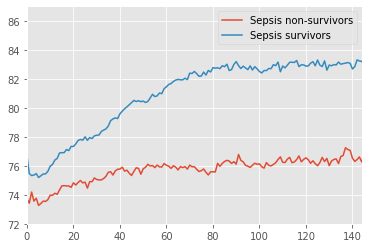

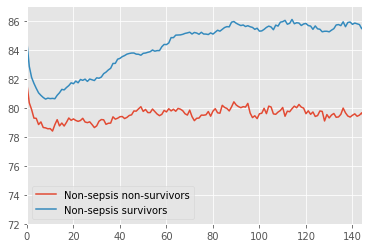

In [42]:
def plot_meanMAP(hourSinceAdm):
    #hourSinceAdm = hourSinceAdm.reset_index(level=(1), drop = False)

    hourSinceAdm['mortality'] = patient.loc[hourSinceAdm.index]['mortality']
    hourSinceAdm['sepsis'] = patient.loc[hourSinceAdm.index]['angus']
    hourSinceAdm['apache'] = patient.loc[hourSinceAdm.index]['apachescore']
    hourSinceAdm['gender'] = patient.loc[hourSinceAdm.index]['gender']

    plt.plot(hourSinceAdm[(hourSinceAdm['sepsis']==1) & (hourSinceAdm['mortality']==1)].groupby(['hourSinceAdm'])[['noninvasivemean']].mean())
    plt.plot(hourSinceAdm[(hourSinceAdm['sepsis']==1) & (hourSinceAdm['mortality']==0)].groupby(['hourSinceAdm'])[['noninvasivemean']].mean())
    plt.legend(['Sepsis non-survivors', 'Sepsis survivors'])
    plt.xlim(0,144)
    plt.ylim(72,87)
    plt.show()

    plt.plot(hourSinceAdm[(hourSinceAdm['sepsis']==0) & (hourSinceAdm['mortality']==1)].groupby(['hourSinceAdm'])[['noninvasivemean']].mean())
    plt.plot(hourSinceAdm[(hourSinceAdm['sepsis']==0) & (hourSinceAdm['mortality']==0)].groupby(['hourSinceAdm'])[['noninvasivemean']].mean())
    plt.legend(['Non-sepsis non-survivors', 'Non-sepsis survivors'])
    plt.xlim(0,144)
    plt.ylim(72,87)
    plt.show()

    
plot_meanMAP(data_median_hourSinceAdm)


# 6. Save the preprocessed data <a class="anchor" id="6"></a>

In [43]:
patient.to_csv('patient_data_extraction.csv')
data.to_csv('map_data_extraction.csv')
data_median_hourSinceAdm.to_csv('map_median.csv')